### Monopoly



Team members: working individually (Dariia Shevchuk 161200)

Selected board game: Monopoly (classic edition)

Short description:
Monopoly is a turn-based board game where players move their pawns around the board using dice, buy properties they land on, pay rent to other players, and manage money with the goal of becoming the last player not bankrupt.

List of in-game items I detect: 
- Board board with fixed square positions and fields.
- 2 pawns
- 2 standard 6-sided dice
- Community / change cards
- players` hands

Events I detect:
- hand is present or not
- move a pawn from one field to another
- roll dice


In [17]:
import os, sys, json, math
from dataclasses import asdict
import numpy as np
import cv2
import matplotlib.pyplot as plt


import detect_board as board
import detect_hand as hand
import detect_cards as cards
import detect_pawns as pawns
import detect_dice as dice

def bgr2rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def show(img_bgr, title="", figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(bgr2rgb(img_bgr))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [18]:
VIDEO_PATH = "data/difficult/4_difficult.mp4" 

def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return {"fps": fps, "n_frames": n, "w": w, "h": h}

def read_frame(video_path, frame_idx):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise ValueError(f"Failed reading frame {frame_idx} from {video_path}")
    return frame

info = get_video_info(VIDEO_PATH)
info


{'fps': 29.97002997002997, 'n_frames': 8978, 'w': 1770, 'h': 1808}

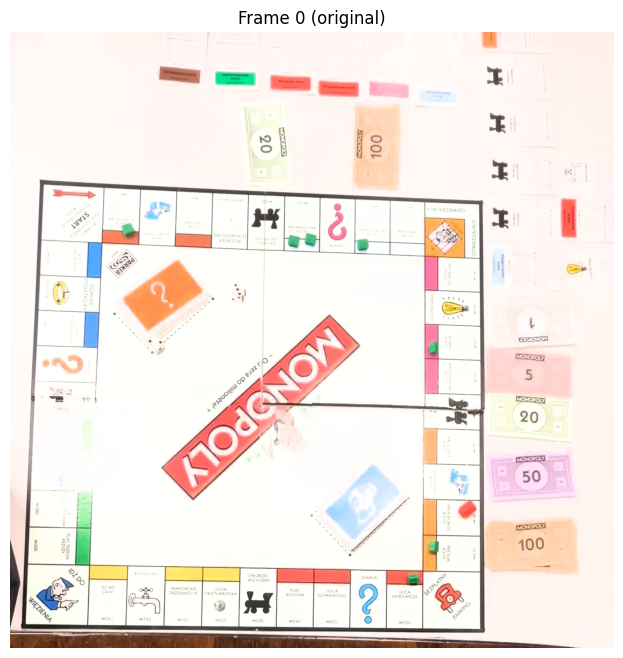

In [19]:
frame0 = read_frame(VIDEO_PATH, frame_idx=0)
show(frame0, "Frame 0 (original)")


### Board calibration: homography + canonical board coordinates

**Goal:** map each video frame to a fixed top-down board coordinate system (square `warp_size × warp_size`) so all later detections become geometry-stable.

**Method:**
- Detect the **board outer quadrilateral** in multiple frames using **Canny edges -> dilation -> contour search -> polygon approximation** (keep the best 4-corner contour above an area threshold).
- Compute a median quad across frames to reduce noise, then estimate a perspective homography to warp the board into a canonical square.
- Detect the inner playing area box in warped space using **Sobel edge profiles** (strong vertical/horizontal gradient peaks) and take the median across frames for stability.


inner_box: (125, 126, 777, 776)
dice_roi: (125, 126, 777, 776)
fields: 40 meta: {'t_left': 125, 't_top': 126, 't_right': 123, 't_bottom': 124, 'cell_x': 72.44444444444444, 'cell_y': 72.22222222222223}


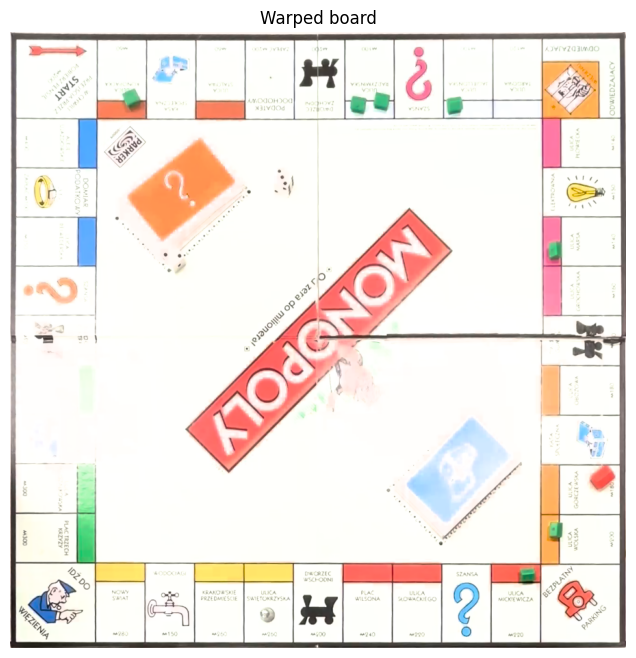

In [20]:
WARP_SIZE = 900

cal_cfg = board.CalibCFG(
    video_path=VIDEO_PATH,
    warp_size=WARP_SIZE,

    blur_ksize=7,
    canny1=60,
    canny2=160,
    dilate_ksize=3,
    approx_eps_ratio=0.02,
    quad_area_ratio_min=0.15,
    max_contours_to_try=12,

    board_sample_frames=80,  
    inner_sample_frames=70,  

    band_ratio=0.30,
    smooth_ksize=51,
    min_margin_ratio=0.06,
)

H, quad_med = board.estimate_homography(VIDEO_PATH, cal_cfg)
inner_box = board.estimate_inner_box_median(VIDEO_PATH, H, cal_cfg)
fields, meta = board.build_monopoly_fields_robust(WARP_SIZE, inner_box)

outer_mask, inner_mask, ring_mask, dice_roi, dice_roi_mask = board.build_masks(WARP_SIZE, inner_box)

frame0 = read_frame(VIDEO_PATH, 0)
warped0 = board.warp_board(frame0, H, WARP_SIZE)

print("inner_box:", inner_box)
print("dice_roi:", dice_roi)
print("fields:", len(fields), "meta:", meta)
show(warped0, "Warped board")


In [21]:
import json
import numpy as np

def save_fields_coords(path, H, warp_size, inner_box, fields, dice_roi):
    def field_centers(fields):
        return [((x1+x2)/2.0, (y1+y2)/2.0) for (x1,y1,x2,y2) in fields]

    payload = {
        "warp_size": int(warp_size),
        "H": np.asarray(H, dtype=float).tolist(),
        "inner_box": [int(v) for v in inner_box],
        "dice_roi": [int(v) for v in dice_roi],
        "fields": []
    }
    centers = field_centers(fields)
    for i, (rect, (cx, cy)) in enumerate(zip(fields, centers)):
        x1,y1,x2,y2 = rect
        payload["fields"].append({
            "id": int(i),
            "rect": [int(x1), int(y1), int(x2), int(y2)],
            "center": [float(cx), float(cy)]
        })

    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

save_fields_coords("outputs/fields_coords.json", H, WARP_SIZE, inner_box, fields, dice_roi)
print("Saved outputs/fields_coords.json")


Saved outputs/fields_coords.json


In [22]:
from types import SimpleNamespace

calib = SimpleNamespace(
    H=H,
    warp_size=WARP_SIZE,
    inner_box=inner_box,
    dice_roi=dice_roi,
    fields=fields
)

print("calib ready:", calib.warp_size, calib.inner_box)


calib ready: 900 (125, 126, 777, 776)


### Board geometry: 40 fields + region masks

**Fields (board squares):**
- Build 40 rectangles by using the detected `inner_box` as a reference.
- Compute border thickness on each side and divide each edge into 9 equal segments to get consistent field rectangles around the ring.

**Masks:**
- `inner_mask`: the central rectangle (used for cards + dice detection).
- `ring_mask`: outer minus inner (used for pawn detection on the track).


In [23]:
def rect_to_xyxy(rect):
    r = rect
    if isinstance(r, np.ndarray):
        r = r.tolist()

    # ((x1,y1),(x2,y2))
    if isinstance(r, (list, tuple)) and len(r) == 2 and isinstance(r[0], (list, tuple)):
        (x1, y1), (x2, y2) = r
    # (x1,y1,x2,y2)
    elif isinstance(r, (list, tuple)) and len(r) == 4:
        x1, y1, x2, y2 = r
    else:
        raise TypeError(f"Unsupported rect format: {type(rect)} -> {rect}")

    x1,y1,x2,y2 = map(int, (x1,y1,x2,y2))
    return min(x1,x2), min(y1,y2), max(x1,x2), max(y1,y2)

def draw_rect(img_bgr, rect, color=(0,255,0), thickness=2, label=None):
    x1,y1,x2,y2 = rect_to_xyxy(rect)
    out = img_bgr.copy()
    cv2.rectangle(out, (x1,y1), (x2,y2), color, thickness)
    if label is not None:
        text = str(label)
        org = (x1, max(0, y1 - 6))
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.7
        # outline
        cv2.putText(out, text, org, font, scale, (0, 0, 0), 6, cv2.LINE_AA)
        # foreground
        cv2.putText(out, text, org, font, scale, color, 2, cv2.LINE_AA)

    return out

def draw_fields(img_bgr, fields, step=1):
    out = img_bgr.copy()
    for i, r in enumerate(fields):
        if step > 1 and (i % step != 0):
            continue
        out = draw_rect(out, r, color=(0,200,255), thickness=2, label=i)
    return out

def draw_quads(img_bgr, quads, color=(255,0,0), thickness=2):
    out = img_bgr.copy()
    for q in quads:
        pts = np.array(q, dtype=np.int32).reshape(-1,2)
        cv2.polylines(out, [pts], True, color, thickness)
    return out

def point_in_rect(pt_xy, rect):
    x, y = pt_xy
    x1,y1,x2,y2 = rect_to_xyxy(rect)
    return (x1 <= x <= x2) and (y1 <= y <= y2)

def assign_field_id(center_xy, fields):
    for i, r in enumerate(fields):
        if point_in_rect(center_xy, r):
            return i
    cx, cy = center_xy
    centers = []
    for r in fields:
        x1,y1,x2,y2 = rect_to_xyxy(r)
        centers.append(((x1+x2)/2, (y1+y2)/2))
    d2 = [(i, (cx-x)**2 + (cy-y)**2) for i,(x,y) in enumerate(centers)]
    return min(d2, key=lambda t: t[1])[0] if d2 else None


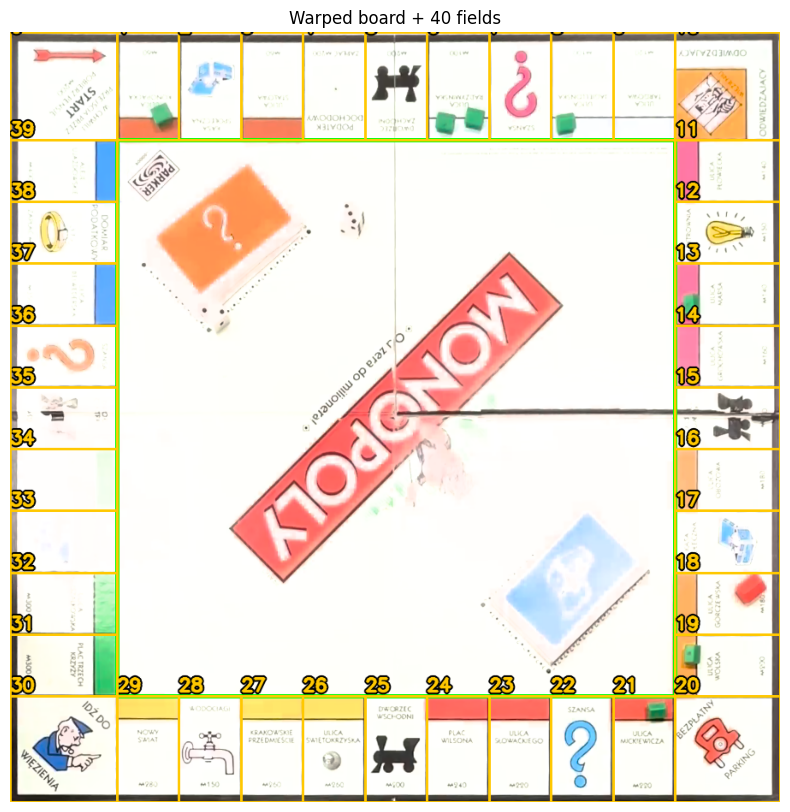

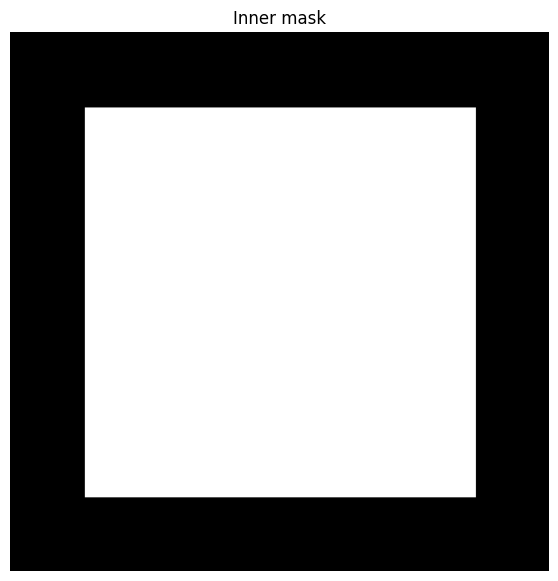

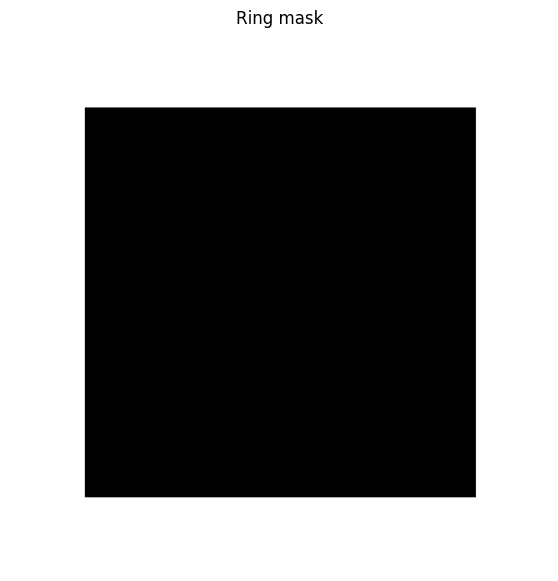

In [24]:
vis = warped0.copy()
vis = draw_rect(vis, calib.inner_box, color=(0,255,0), thickness=3)
vis = draw_fields(vis, calib.fields, step=1)
show(vis, "Warped board + 40 fields", figsize=(10,10))

show(cv2.cvtColor(inner_mask, cv2.COLOR_GRAY2BGR), "Inner mask", figsize=(7,7))
show(cv2.cvtColor(ring_mask, cv2.COLOR_GRAY2BGR), "Ring mask", figsize=(7,7))

### Hand detection (motion and skin)

Goal: detect time intervals when a hand is on the board to avoid interpreting occlusions as game events.

Nethod:
- Build a running grayscale **background model** using `accumulateWeighted`.
- For each frame compute:
  - **skin mask** in HSV (hand-color range),
  - **motion mask** via abs-diff vs background + threshold,
  - combine them with **AND** to isolate moving skin-like regions.
- Decide `hand_present` if the hand-mask pixel ratio in ROI exceeds a threshold.
- Convert frame-wise booleans into **time intervals** and merge close intervals for stability.


In [25]:
params = hand.Params() 

# set ROI but its not needed here
roi = None  

hand_result = hand.process_video(VIDEO_PATH, roi=roi, p=params, debug=False)

os.makedirs("outputs", exist_ok=True)
with open("outputs/hand_periods.json", "w") as f:
    json.dump(hand_result, f, indent=2)

hand_result.keys(), hand_result["hand_present_intervals"][:5]


(dict_keys(['video', 'fps', 'total_seconds', 'roi', 'params', 'hand_present_intervals', 'no_hand_intervals']),
 [(1.8351666666666666, 5.4054),
  (8.775433333333334, 21.755066666666668),
  (39.10573333333333, 41.4414),
  (44.8448, 45.97926666666667),
  (50.78406666666667, 55.088366666666666)])

In [26]:
def warp_any(frame_bgr, H, warp_size):
    if hasattr(board, "warp_frame"):
        return board.warp_frame(frame_bgr, H, warp_size)
    return board.warp_board(frame_bgr, H, warp_size)


In [27]:
def is_hand_present_at_t(hand_json, t):
    for a,b in hand_json["hand_present_intervals"]:
        if a <= t <= b:
            return True
    return False

def majority_vote(seq):
    from collections import Counter
    c = Counter(tuple(x) for x in seq if x is not None)
    return list(c.most_common(1)[0][0]) if c else None


### dice detection code from my earlier attempts. this one cell below is to be removed, its an isolated approach that i used for testing dice detection

In [28]:
# %% [markdown]
# ### (Legacy) Dice detection via background-diff + pip counting
# This is the older approach from detect.py: foreground mask vs. clean warped background -> dice candidates -> pip count.

# %%
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple
import cv2
import numpy as np

BBox = Tuple[int, int, int, int]  # (x1,y1,x2,y2) in WARPED coordinates


def _binary_cleanup(m: np.ndarray, open_k: int = 3, close_k: int = 7, it_open: int = 1, it_close: int = 1) -> np.ndarray:
    out = m
    if open_k and open_k > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k, open_k))
        out = cv2.morphologyEx(out, cv2.MORPH_OPEN, k, iterations=int(it_open))
    if close_k and close_k > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k, close_k))
        out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, k, iterations=int(it_close))
    return out


def _clip_bbox(bb: BBox, Hh: int, Ww: int, pad: int = 0) -> Optional[BBox]:
    x1, y1, x2, y2 = map(int, bb)
    x1 -= int(pad); y1 -= int(pad); x2 += int(pad); y2 += int(pad)
    x1 = max(0, min(x1, Ww - 1))
    y1 = max(0, min(y1, Hh - 1))
    x2 = max(0, min(x2, Ww))
    y2 = max(0, min(y2, Hh))
    if x2 <= x1 or y2 <= y1:
        return None
    return (x1, y1, x2, y2)


def contour_components(bin_mask: np.ndarray) -> List[Dict[str, Any]]:
    cnts, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out: List[Dict[str, Any]] = []
    for c in cnts:
        area = float(cv2.contourArea(c))
        if area <= 0:
            continue
        x, y, w, h = cv2.boundingRect(c)
        bbox = (int(x), int(y), int(x + w), int(y + h))
        hull = cv2.convexHull(c)
        hull_area = float(cv2.contourArea(hull))
        solidity = float(area / hull_area) if hull_area > 1e-6 else 0.0
        extent = float(area / float(w * h + 1e-6))
        out.append({
            "area": int(round(area)),
            "bbox": bbox,
            "solidity": solidity,
            "extent": extent,
        })
    out.sort(key=lambda d: d["area"], reverse=True)
    return out


def foreground_mask_from_bg(
    warped_bgr: np.ndarray,
    bg_bgr: np.ndarray,
    roi_mask: Optional[np.ndarray] = None,
    thresh: int = 22,
    open_k: int = 3,
    close_k: int = 7,
) -> np.ndarray:
    if roi_mask is None:
        roi_mask = np.ones(warped_bgr.shape[:2], dtype=np.uint8) * 255

    diff = cv2.absdiff(warped_bgr, bg_bgr)
    g = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, m = cv2.threshold(g, int(thresh), 255, cv2.THRESH_BINARY)
    m = cv2.bitwise_and(m, m, mask=roi_mask)
    m = _binary_cleanup(m, open_k=open_k, close_k=close_k, it_open=1, it_close=2)
    return m


def detect_dice_candidates_from_fg(fg_inner: np.ndarray, inner_mask: np.ndarray, max_dice: int = 2, topk: int = 20) -> List[BBox]:
    comps = contour_components(fg_inner)
    inner_area = float(max(1, np.count_nonzero(inner_mask)))

    cand: List[Tuple[float, BBox]] = []
    for c in comps[:topk]:
        bb = c["bbox"]
        w = bb[2] - bb[0]
        h = bb[3] - bb[1]
        if w < 5 or h < 5:
            continue
        ar = float(w) / float(h + 1e-6)
        area_ratio = float(c["area"]) / inner_area

        if area_ratio < 0.0003 or area_ratio > 0.7:
            continue
        if c["extent"] < 0.10:
            continue
        if c["solidity"] < 0.1:
            continue

        if 0.70 <= ar <= 1.10:
            score = (1.0 - abs(ar - 1.0)) * 2.0 + np.log(float(c["area"]) + 1.0) * 0.2 + float(c["solidity"]) * 0.5
            cand.append((float(score), bb))

    cand.sort(key=lambda t: t[0], reverse=True)
    return [bb for _, bb in cand[:max_dice]]


def crop_die_top_face_square_with_border(
    die_bgr: np.ndarray,
    out_size: int = 270,
    upscale_long_side: int = 650,
    ab_thr: int = 38,
    L_min: int = 170,
    L_quantile: int = 92,
    open_k: int = 7,
    close_k: int = 21,
    close_iter: int = 2,
    pad_frac: float = 0.03,
) -> np.ndarray:
    def _resize_long(bgr: np.ndarray, target: int) -> np.ndarray:
        h, w = bgr.shape[:2]
        s = float(target) / max(h, w)
        if abs(s - 1.0) < 1e-6:
            return bgr.copy()
        return cv2.resize(bgr, (max(1, int(w * s)), max(1, int(h * s))),
                          interpolation=cv2.INTER_CUBIC if s > 1 else cv2.INTER_AREA)

    def _order_quad(pts4: np.ndarray) -> np.ndarray:
        pts = np.array(pts4, dtype=np.float32)
        s = pts.sum(axis=1)
        d = np.diff(pts, axis=1).reshape(-1)
        tl = pts[np.argmin(s)]
        br = pts[np.argmax(s)]
        tr = pts[np.argmin(d)]
        bl = pts[np.argmax(d)]
        return np.stack([tl, tr, br, bl], axis=0)

    bgr = _resize_long(die_bgr, upscale_long_side)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, bb = cv2.split(lab)

    neutral = ((np.abs(a.astype(np.int16) - 128) <= int(ab_thr)) &
               (np.abs(bb.astype(np.int16) - 128) <= int(ab_thr)))
    if np.any(neutral):
        thr = max(int(L_min), int(np.percentile(L[neutral], int(L_quantile))))
    else:
        thr = int(L_min)

    bright = L >= thr
    mask = (neutral & bright).astype(np.uint8) * 255
    ok = int(open_k) | 1
    ck = int(close_k) | 1
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ok, ok)), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ck, ck)), iterations=int(close_iter))

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        Hh, Ww = bgr.shape[:2]
        side = min(Hh, Ww)
        y0 = (Hh - side) // 2
        x0 = (Ww - side) // 2
        return cv2.resize(bgr[y0:y0 + side, x0:x0 + side], (out_size, out_size), interpolation=cv2.INTER_AREA)

    cnt = max(cnts, key=cv2.contourArea)
    if cv2.contourArea(cnt) < 80:
        return cv2.resize(bgr, (out_size, out_size), interpolation=cv2.INTER_AREA)

    peri = cv2.arcLength(cnt, True)
    quad = None
    for eps_frac in (0.02, 0.03, 0.04, 0.05, 0.06):
        approx = cv2.approxPolyDP(cnt, eps_frac * peri, True)
        if len(approx) == 4:
            quad = approx.reshape(4, 2).astype(np.float32)
            break
    if quad is None:
        rect = cv2.minAreaRect(cnt)
        quad = cv2.boxPoints(rect).astype(np.float32)

    src = _order_quad(quad)
    c = src.mean(axis=0, keepdims=True)
    src = (src - c) * (1.0 + float(pad_frac)) + c

    dst = np.array([[0, 0], [out_size - 1, 0], [out_size - 1, out_size - 1], [0, out_size - 1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(bgr, M, (out_size, out_size), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


def count_pips_on_cropped_top_face(
    face_bgr: np.ndarray,
    ab_thr: int = 55,
    L_lo: int = 165,
    open_k: int = 3,
    close_k: int = 9,
    close_iter: int = 1,
    border_frac: float = 0.045,
    min_area_frac: float = 0.0012,
    max_area_frac: float = 0.06,
    max_aspect: float = 1.6,
) -> Tuple[int, np.ndarray]:
    bgr = face_bgr.copy()
    h, w = bgr.shape[:2]
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, bb = cv2.split(lab)

    neutral = ((np.abs(a.astype(np.int16) - 128) <= int(ab_thr)) &
               (np.abs(bb.astype(np.int16) - 128) <= int(ab_thr))).astype(np.uint8) * 255
    bright_enough = (L >= int(L_lo)).astype(np.uint8) * 255
    face_mask = cv2.bitwise_and(neutral, bright_enough)

    ok = int(open_k) | 1
    ck = int(close_k) | 1
    face_mask = cv2.morphologyEx(face_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ok, ok)), iterations=1)
    face_mask = cv2.morphologyEx(face_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ck, ck)), iterations=int(close_iter))

    pips = cv2.bitwise_not(face_mask)

    bx = int(border_frac * w)
    by = int(border_frac * h)
    pips[:by, :] = 0
    pips[-by:, :] = 0
    pips[:, :bx] = 0
    pips[:, -bx:] = 0

    num, _labels, stats, centroids = cv2.connectedComponentsWithStats(pips, connectivity=8)

    area_img = h * w
    min_area = int(min_area_frac * area_img)
    max_area = int(max_area_frac * area_img)

    centers = []
    for i in range(1, num):
        _x, _y, ww, hh, aarea = stats[i]
        if aarea < min_area or aarea > max_area:
            continue
        asp = max(ww / max(1, hh), hh / max(1, ww))
        if asp > max_aspect:
            continue
        centers.append((float(centroids[i][0]), float(centroids[i][1])))

    pip_count = int(min(max(len(centers), 0), 6))
    return pip_count, pips


def read_dice_value_from_bbox(warped_bgr: np.ndarray, bb: BBox, out_size: int = 270) -> Tuple[Optional[int], Dict[str, Any]]:
    Hh, Ww = warped_bgr.shape[:2]
    bb2 = _clip_bbox(bb, Hh, Ww, pad=4)
    if bb2 is None:
        return None, {"bbox": bb, "ok": False}
    x1, y1, x2, y2 = bb2
    crop = warped_bgr[y1:y2, x1:x2]
    face = crop_die_top_face_square_with_border(crop, out_size=out_size)
    v, pip_mask = count_pips_on_cropped_top_face(face)
    return int(v), {"bbox": bb2, "ok": True, "face": face, "pip_mask": pip_mask}


@dataclass
class LegacyDiceDetections:
    boxes_warped: List[BBox]                 # xyxy boxes
    dice_values: Optional[List[int]]
    debug: Dict[str, Any]


def legacy_detect_dice_on_warped(
    warped_bgr: np.ndarray,
    bg_clean_warped_bgr: np.ndarray,
    inner_mask: np.ndarray,
    diff_thresh: int = 22,
    max_dice: int = 2,
) -> LegacyDiceDetections:
    fg = foreground_mask_from_bg(
        warped_bgr=warped_bgr,
        bg_bgr=bg_clean_warped_bgr,
        roi_mask=inner_mask,
        thresh=diff_thresh,
        open_k=3,
        close_k=1,
    )

    dice_bboxes = detect_dice_candidates_from_fg(fg, inner_mask, max_dice=max_dice, topk=20)

    vals: List[Optional[int]] = []
    per_die_dbg: List[Dict[str, Any]] = []
    for bb in dice_bboxes:
        v, d = read_dice_value_from_bbox(warped_bgr, bb, out_size=270)
        vals.append(v)
        per_die_dbg.append(d)

    dice_values = [v for v in vals if v is not None]
    dice_values = dice_values if len(dice_values) else None

    overlay = warped_bgr.copy()
    for i, bb in enumerate(dice_bboxes):
        x1, y1, x2, y2 = bb
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 255), 3)
        lab = f"die{i+1}"
        if dice_values is not None and i < len(dice_values):
            lab += f"={dice_values[i]}"
        cv2.putText(overlay, lab, (x1, max(20, y1 - 8)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 6, cv2.LINE_AA)
        cv2.putText(overlay, lab, (x1, max(20, y1 - 8)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2, cv2.LINE_AA)

    dbg = {"fg_inner": fg, "dice_bboxes": dice_bboxes, "per_die": per_die_dbg, "overlay": overlay}
    return LegacyDiceDetections(boxes_warped=dice_bboxes, dice_values=dice_values, debug=dbg)


# --- Quick single-frame test helper (optional) ---
def legacy_test_on_frame(frame_idx: int = 150, diff_thresh: int = 22):
    fr = read_frame(VIDEO_PATH, frame_idx)
    warped = warp_any(fr, calib.H, calib.warp_size)

    # Use the same background image the pawn pipeline uses (static warped_board_clean.png by default)
    bg_cfg = pawns.PawnBGCFG(mode="static", video_path=VIDEO_PATH)
    bg_provider = pawns.PawnBackgroundProvider(bg_cfg, calib.H, calib.warp_size, roi_mask=inner_mask)
    bg_clean = bg_provider.get()

    det = legacy_detect_dice_on_warped(warped, bg_clean, inner_mask, diff_thresh=diff_thresh)
    show(det.debug["overlay"], f"Legacy dice overlay @ frame {frame_idx}")
    show(cv2.cvtColor(det.debug["fg_inner"], cv2.COLOR_GRAY2BGR), "Legacy FG mask (inner)")
    return det


In [29]:
# det_legacy = legacy_test_on_frame(frame_idx=200, diff_thresh=30)
# det_legacy.dice_values, det_legacy.boxes_warped


### Pipeline used for running detections on the videos

In [30]:
from dataclasses import dataclass
from typing import Optional, Tuple, List

@dataclass
class PawnState:
    stable_field: Optional[int] = None
    candidate_field: Optional[int] = None
    candidate_count: int = 0
    last_center: Optional[Tuple[float, float]] = None

class PawnMoveDebouncer:
    def __init__(self, stable_frames: int, still_px: float = 6.0):
        self.stable_frames = int(stable_frames)
        self.still_px = float(still_px)
        self.states = [PawnState(), PawnState()]

    @staticmethod
    def _dist(a, b):
        return ((a[0]-b[0])**2 + (a[1]-b[1])**2) ** 0.5

    def update(self, pawn_centers: List[Optional[Tuple[float,float]]],
               pawn_fields: List[Optional[int]],
               hand_now: bool) -> List[dict]:
        """
        Returns list of move events like:
        {"type":"PAWN_MOVED", "pawn":0, "from":12, "to":15}
        """
        evs = []

        # If hand is present: don't "learn" transitions (prevents occlusion-triggered moves)
        if hand_now:
            for i in range(2):
                st = self.states[i]
                st.candidate_field = None
                st.candidate_count = 0
                st.last_center = pawn_centers[i] if i < len(pawn_centers) else None
            return evs

        for i in range(2):
            st = self.states[i]
            c = pawn_centers[i] if i < len(pawn_centers) else None
            f = pawn_fields[i] if i < len(pawn_fields) else None

            # If missing detection, don't commit anything; just reset candidate
            if c is None or f is None:
                st.candidate_field = None
                st.candidate_count = 0
                st.last_center = c
                continue

            # Initialize stable_field on first confident observation
            if st.stable_field is None:
                st.stable_field = int(f)
                st.last_center = c
                continue

            # Stillness check (helps a lot with jitter)
            is_still = True
            if st.last_center is not None:
                is_still = (self._dist(c, st.last_center) <= self.still_px)
            st.last_center = c

            if not is_still:
                # pawn is moving -> don't accumulate stability
                st.candidate_field = None
                st.candidate_count = 0
                continue

            # Debounce field change
            if int(f) == st.stable_field:
                st.candidate_field = None
                st.candidate_count = 0
                continue

            if st.candidate_field != int(f):
                st.candidate_field = int(f)
                st.candidate_count = 1
            else:
                st.candidate_count += 1

            if st.candidate_count >= self.stable_frames:
                evs.append({
                    "type": "PAWN_MOVED",
                    "pawn": i,
                    "from": int(st.stable_field),
                    "to": int(st.candidate_field),
                })
                st.stable_field = int(st.candidate_field)
                st.candidate_field = None
                st.candidate_count = 0

        return evs


In [31]:
# %%
def run_full_video(
    video_path,
    calib,
    hand_json,
    out_video_path="outputs/annotated.mp4",
    out_events_path="outputs/events.json",
    out_jsonl_path="outputs/detections.jsonl",
    max_frames=None,
    stable_n=8
):
    os.makedirs("outputs", exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_video_path, fourcc, fps, (calib.warp_size, calib.warp_size))

    # Background provider for pawn detection (use the actual video_path here)
    bg_cfg = pawns.PawnBGCFG(mode="static", video_path=video_path)
    bg_provider = pawns.PawnBackgroundProvider(bg_cfg, calib.H, calib.warp_size, roi_mask=ring_mask)
    pawn_cfg = pawns.PawnCFG()

    # --- Pawn move debouncer setup ---
    stable_seconds_pawn = 0.7  # tune: 0.5..1.5 (how long pawn must "sit" on new field)
    pawn_stable_frames = max(3, int(round(fps * stable_seconds_pawn)))
    pawn_debouncer = PawnMoveDebouncer(stable_frames=pawn_stable_frames, still_px=8.0)
    prev_centers = None  # for identity-stable pawn tracking

    events = []
    last_hand = False

    dice_hist = []
    last_dice_stable = None

    # Overlay message for last significant event (e.g., pawn moved from->to)
    last_overlay_text = ""
    last_overlay_t = -1.0
    overlay_hold_seconds = 1.8

    f = open(out_jsonl_path, "w")
    idx = 0

    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if max_frames is not None and idx >= max_frames:
            break

        t = idx / fps
        warped = warp_any(frame, calib.H, calib.warp_size)

        # detections
        card_det = cards.detect_cards_in_inner_field(warped, calib.inner_box)
        dice_det = dice.detect_dice_in_inner_field(warped, calib.inner_box) # <<< CURRENT dice module
        

        #### TEST 
        
        # bg_clean = bg_provider.get()  # already exists in run_full_video()
        # dice_det = legacy_detect_dice_on_warped(warped, bg_clean, inner_mask, diff_thresh=35)

        #### 

        pawn_list, _, _ = pawns.detect_pawns_from_frame(
            frame_bgr=frame,
            H=calib.H,
            warp_size=calib.warp_size,
            ring_mask=ring_mask,
            bg=bg_provider,
            prev_centers=prev_centers,  # <<< IMPORTANT (keeps pawn0/pawn1 identity stable)
            cfg=pawn_cfg,
            return_debug_images=False
        )

        # Build fixed-length (2) pawn centers and pawn fields
        pawn_centers = [None, None]
        pawn_fields = [None, None]
        for i in range(min(2, len(pawn_list))):
            cx, cy = pawn_list[i]["center"]
            pawn_centers[i] = (cx, cy)
            pawn_fields[i] = assign_field_id((cx, cy), calib.fields)

        # Update prev_centers for the next frame (identity matching)
        prev_centers = [c for c in pawn_centers if c is not None]

        hand_now = is_hand_present_at_t(hand_json, t)

        # events: hand
        if (not last_hand) and hand_now:
            ev = {"t": t, "type": "HAND_APPEARS"}
            events.append(ev)
            last_overlay_text = "HAND_APPEARS"
            last_overlay_t = t

        if last_hand and (not hand_now):
            ev = {"t": t, "type": "HAND_DISAPPEARS"}
            events.append(ev)
            last_overlay_text = "HAND_DISAPPEARS"
            last_overlay_t = t

        # events: dice stability
        dice_vals = dice_det.dice_values if dice_det.dice_values else None
        dice_hist.append(dice_vals)
        if len(dice_hist) > stable_n:
            dice_hist.pop(0)
        dice_stable = majority_vote(dice_hist) if len(dice_hist) == stable_n else None
        if dice_stable is not None and dice_stable != last_dice_stable:
            ev = {"t": t, "type": "DICE_STABLE", "dice": dice_stable}
            events.append(ev)
            last_dice_stable = dice_stable
            last_overlay_text = f"DICE_STABLE {dice_stable}"
            last_overlay_t = t

        # events: pawn moved (debounced + hand-gated)
        move_evs = pawn_debouncer.update(pawn_centers, pawn_fields, hand_now)
        for e in move_evs:
            e["t"] = t
            events.append(e)
            # <<< NEW: overlay label with from/to
            last_overlay_text = f"PAWN{e['pawn']} MOVED {e['from']} -> {e['to']}"
            last_overlay_t = t

        last_hand = hand_now

        # detections record (store raw per-frame + also stable fields for debugging)
        stable_fields_now = [st.stable_field for st in pawn_debouncer.states]
        rec = {
            "frame": idx,
            "t": t,
            "hand": bool(hand_now),
            "dice": dice_vals,
            "pawn_fields": pawn_fields,
            "pawn_fields_stable": stable_fields_now,
            "n_cards": len(getattr(card_det, "quads_warped", []) or []),
        }
        f.write(json.dumps(rec) + "\n")

        # annotate
        vis = warped.copy()
        vis = draw_rect(vis, calib.inner_box, color=(0,255,0), thickness=2)

        # --- Cards: draw quads + label card1/card2 ---
        quads = getattr(card_det, "quads_warped", None) or []
        if quads:
            for j, q in enumerate(quads):
                pts = np.array(q, dtype=np.int32).reshape(-1, 2)
                cv2.polylines(vis, [pts], True, (255, 0, 0), 3)

                if j < 2:
                    label = f"card{j+1}"
                    # place label near the top-most point of the quad
                    top_idx = int(np.argmin(pts[:, 1]))
                    lx, ly = int(pts[top_idx, 0]), int(pts[top_idx, 1]) - 8
                    ly = max(ly, 15)

                    font = cv2.FONT_HERSHEY_SIMPLEX
                    scale = 0.9
                    cv2.putText(vis, label, (lx, ly), font, scale, (0, 0, 0), 6, cv2.LINE_AA)
                    cv2.putText(vis, label, (lx, ly), font, scale, (255, 255, 255), 2, cv2.LINE_AA)

        if getattr(dice_det, "boxes_warped", None):
            for i, b in enumerate(dice_det.boxes_warped):
                label = str(dice_det.dice_values[i]) if dice_det.dice_values else "die"
                vis = draw_rect(vis, b, color=(0,255,255), thickness=3, label=label)

        # Draw pawns (show both raw field and stable field)
        for i, p in enumerate(pawn_list[:2]):
            cx, cy = p["center"]
            raw_fid = assign_field_id((cx, cy), calib.fields)
            stable_fid = pawn_debouncer.states[i].stable_field
            vis = draw_rect(
                vis,
                p["bbox"],
                color=(255,0,255),
                thickness=3,
                label=f"pawn{i} raw={raw_fid} stable={stable_fid}"
            )

        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.9

        txt1 = f"t={t:.2f}s hand={int(hand_now)}"
        org1 = (10, 30)
        cv2.putText(vis, txt1, org1, font, scale, (0, 0, 0), 6, cv2.LINE_AA)
        cv2.putText(vis, txt1, org1, font, scale, (255, 255, 255), 2, cv2.LINE_AA)

        # <<< NEW: show detailed pawn-move overlay text for a short time
        if last_overlay_text and (t - last_overlay_t) <= overlay_hold_seconds:
            txt2 = last_overlay_text
            org2 = (10, 65)
            cv2.putText(vis, txt2, org2, font, scale, (0, 0, 0), 6, cv2.LINE_AA)
            cv2.putText(vis, txt2, org2, font, scale, (255, 255, 255), 2, cv2.LINE_AA)

        writer.write(vis)
        idx += 1

    f.close()
    cap.release()
    writer.release()

    with open(out_events_path, "w") as ff:
        json.dump(events, ff, indent=2)

    return {"out_video": out_video_path, "out_events": out_events_path, "out_jsonl": out_jsonl_path, "n_events": len(events)}


In [32]:
result = run_full_video(
    VIDEO_PATH,
    calib=calib,
    hand_json=hand_result,  
    out_video_path="outputs/annotated.mp4",
    out_events_path="outputs/events.json",
    out_jsonl_path="outputs/detections.jsonl",
    max_frames=50000,   ### NULL 
    stable_n=8
)
result


{'out_video': 'outputs/annotated.mp4',
 'out_events': 'outputs/events.json',
 'out_jsonl': 'outputs/detections.jsonl',
 'n_events': 79}